<a href="https://colab.research.google.com/github/capofwesh20/Analysis-of-NHTSA-complaints/blob/main/Training_notebook_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Relevant libraries and functions
from __future__ import print_function
import random
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np, h5py
import os, time, sys
import tensorflow as tf
import keras
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Input, SpatialDropout2D, UpSampling2D, MaxPooling2D, concatenate, SeparableConv2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, Layer
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Input, add, Conv3D, Reshape
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger
from itertools import cycle
from sklearn import metrics
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.utils as utils
import ipywidgets as widgets
from IPython.display import display
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import tifffile as tiff
from keras.models import load_model
from skimage.metrics import structural_similarity as compare_ssim

In [ ]:
f_data = '/content/drive/MyDrive/work1' # Directory with training data
stacks = os.listdir(f_data)
numS = len(stacks)
numS

10000

# **SETTING UP THE IMAGES FOR TRAINING**

In [ ]:


# Directory containing training data
p_data = f_data  # Ensure f_data is defined with the correct path
stacks = os.listdir(p_data)
numS = len(stacks)

nTG = 256  # Number of time-points
xX = 32
yY = 32

# Initialize arrays to store data
tpsfD = np.zeros((numS, nTG, xX, yY, 1), dtype=np.float32)
t1 = np.zeros((numS, xX, yY, 1), dtype=np.float32)
t2 = np.zeros((numS, xX, yY, 1), dtype=np.float32)
a1 = np.zeros((numS, xX, yY, 1), dtype=np.float32)
#a2 = np.zeros((numS, xX, yY, 1), dtype=np.float32)
offset = np.zeros((numS, xX, yY, 1), dtype=np.float32)

# Load data
for i, d in enumerate(stacks):
    # Load NPZ file
    data = np.load(os.path.join(p_data, d))

    # Transpose the data to match the expected shape and save values to respective arrays
    tpsfD[i, :, :, :, 0] = np.transpose(data['sigD'], (2, 0, 1))
    t1[i, :, :, 0] = data['t1']
    t2[i, :, :, 0] = data['t2']
    a1[i, :, :, 0] = data['a1']
    #a2[i, :, :, 0] = data['a2']
    offset[i, :, :, 0] = data['offset']

# Adjust the axis if needed
tpsfD = np.moveaxis(tpsfD, 1, -2)


In [ ]:
# Ensure TPSF voxel shape is correct dimensionality (# samples, x, y, time-points, 1)
tpsfD.shape

(10000, 32, 32, 256, 1)

In [ ]:
print(t1.shape, t2.shape, a1.shape)


(10000, 32, 32, 1) (10000, 32, 32, 1) (10000, 32, 32, 1)


# **UNDERSTANDING THE TRAINING DATA**

In [ ]:
# Relevant resblock functions (Keras API)
def resblock_2D(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

def resblock_2D_BN(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def resblock_3D_BN(num_filters, size_filter, x):
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def xCeptionblock_2D_BN(num_filters, size_filter, x):
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

In [ ]:
modelD = None
xX = 32;
yY = 32;

t_data = Input(shape=(xX, yY, 256,1))
tpsf = t_data

# # # # # # # # 3D-Model # # # # # # # #

tpsf = Conv3D(50,kernel_size=(1,1,10),strides=(1,1,5), padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_3D_BN(50, (1,1,5), tpsf)
tpsf = Reshape((xX,yY,2600))(tpsf)
tpsf = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_2D_BN(256, 1, tpsf)
tpsf = resblock_2D_BN(256, 1, tpsf)

# Short-lifetime branch
imgT1 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgT1 = BatchNormalization()(imgT1)
imgT1 = Activation('relu')(imgT1)
imgT1 = Conv2D(32, 1, padding='same', activation=None)(imgT1)
imgT1 = BatchNormalization()(imgT1)
imgT1 = Activation('relu')(imgT1)
imgT1 = Conv2D(1, 1, padding='same', activation=None)(imgT1)
imgT1 = Activation('relu')(imgT1)

#Long-lifetime branch
imgT2 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgT2 = BatchNormalization()(imgT2)
imgT2 = Activation('relu')(imgT2)
imgT2 = Conv2D(32, 1, padding='same', activation=None)(imgT2)
imgT2 = BatchNormalization()(imgT2)
imgT2 = Activation('relu')(imgT2)
imgT2 = Conv2D(1, 1, padding='same', activation=None)(imgT2)
imgT2 = Activation('relu')(imgT2)

# a1 branch
imga1 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imga1 = BatchNormalization()(imga1)
imga1 = Activation('relu')(imga1)
imga1 = Conv2D(32, 1, padding='same', activation=None)(imga1)
imga1 = BatchNormalization()(imga1)
imga1 = Activation('relu')(imga1)
imga1 = Conv2D(1, 1, padding='same', activation=None)(imga1)
imga1 = Activation('relu')(imga1)

# Amplitude-Ratio branch
# imga2 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
# imga2 = BatchNormalization()(imga2)
# imga2 = Activation('relu')(imga2)
# imga2 = Conv2D(32, 1, padding='same', activation=None)(imga2)
# imga2 = BatchNormalization()(imga2)
# imga2 = Activation('relu')(imga2)
# imga2 = Conv2D(1, 1, padding='same', activation=None)(imga2)
# imga2 = Activation('relu')(imga2)

# Offset Branch
# imgA0 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
# imgA0 = BatchNormalization()(imgA0)
# imgA0 = Activation('relu')(imgA0)
# imgA0 = Conv2D(32, 1, padding='same', activation=None)(imgA0)
# imgA0 = BatchNormalization()(imgA0)
# imgA0 = Activation('relu')(imgA0)
# imgA0 = Conv2D(1, 1, padding='same', activation=None)(imgA0)
# imgA0 = Activation('relu')(imgA0)


# Offset Branch (Final layer without activation)
imgA0 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgA0 = BatchNormalization()(imgA0)
imgA0 = Activation('relu')(imgA0)
imgA0 = Conv2D(32, 1, padding='same', activation=None)(imgA0)
imgA0 = BatchNormalization()(imgA0)
imgA0 = Activation('relu')(imgA0)
imgA0 = Conv2D(1, 1, padding='same', activation=None)(imgA0)  # Final layer without activation
#imgA0 = Activation('relu')(imgA0)

modelD = Model(inputs=[t_data], outputs=[imgT1, imgT2, imga1, imgA0])
rmsprop = RMSprop(learning_rate = 1e-5)

modelD.compile(loss='mse',
              optimizer=rmsprop,
              metrics=[['mae'], ['mae'],  ['mae'], ['mae']])


# modelD = Model(inputs=[t_data], outputs=[imgT1, imgT2, imga1])
# rmsprop = RMSprop(learning_rate = 1e-5)

# modelD.compile(loss='mse',
#               optimizer=rmsprop,
#               metrics=[['mae'], ['mae'], ['mae']])



In [ ]:
modelD.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 256, 1) │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 32, 32, 52, 50) │            550 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 32, 32, 52, 50) │            200 │ conv3d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 32, 32, 52, 50) │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 52, 50) │         12,550 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 32, 32, 52, 50) │            200 │ conv3d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 32, 32, 52, 50) │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 52, 50) │         12,550 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 32, 32, 52, 50) │            200 │ conv3d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 32, 32, 52, 50) │              0 │ batch_normalization_1… │
│                           │                        │                │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 32, 32, 52, 50) │              0 │ add_3[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 32, 32, 2600)   │              0 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 32, 32, 256)    │        665,856 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 32, 32, 256)    │          1,024 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 32, 32, 256)    │              0 │ batch_normalization_1… │
│ (Activation)         

 Total params: 1,084,045 (4.14 MB)

 Trainable params: 1,080,097 (4.12 MB)

 Non-trainable params: 3,948 (15.42 KB)

In [ ]:
# # Input shape compatibility
print("Model input shape:", modelD.input_shape)


# # Output shape compatibility (for multiple outputs)
for i, output_shape in enumerate(modelD.output_shape):
    print(f"Model output shape {i+1}:", output_shape)



Model input shape: (None, 32, 32, 256, 1)
Model output shape 1: (None, 32, 32, 1)
Model output shape 2: (None, 32, 32, 1)
Model output shape 3: (None, 32, 32, 1)
Model output shape 4: (None, 32, 32, 1)


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        return lr * 0.8
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

In [ ]:
fN = 'wawa_now_norm1'  # Assign some name for weights and training/validation loss curves here

# Save loss curve (mse) and MAE information over all trained epochs. (monitor = '' can be changed to focus on other tau parameters)
modelCheckPoint = ModelCheckpoint(filepath=fN+'.keras',
                                  monitor='val_loss',
                                  save_best_only=True,
                                  verbose=0)

# Train network (80/20 train/validation split, batch_size=20 recommended, nb_epoch may vary based on application)
csv_logger = CSVLogger(fN+'.log')
history = modelD.fit([tpsfD], [t1, t2, a1, offset],
                     validation_split=0.2,
                     batch_size=20, epochs=200, verbose=1, shuffle=True,
                     callbacks=[csv_logger, modelCheckPoint, lr_scheduler])



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - activation_11_mae: 0.1497 - activation_14_mae: 0.3580 - activation_17_mae: 0.2179 - conv2d_17_mae: 0.2409 - loss: 1.1668 - val_activation_11_mae: 0.0581 - val_activation_14_mae: 0.1048 - val_activation_17_mae: 0.0518 - val_conv2d_17_mae: 0.0790 - val_loss: 0.1119 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - activation_11_mae: 0.0403 - activation_14_mae: 0.0908 - activation_17_mae: 0.0378 - conv2d_17_mae: 0.0290 - loss: 0.0691 - val_activation_11_mae: 0.0323 - val_activation_14_mae: 0.0831 - val_activation_17_mae: 0.0304 - val_conv2d_17_mae: 0.0387 - val_loss: 0.0551 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - activ

In [ ]:
# model.summary()
# #

In [ ]:
print(history.history.keys())


dict_keys(['activation_11_mae', 'activation_14_mae', 'activation_17_mae', 'conv2d_17_mae', 'loss', 'val_activation_11_mae', 'val_activation_14_mae', 'val_activation_17_mae', 'val_conv2d_17_mae', 'val_loss', 'learning_rate'])


In [ ]:
def plot_metric(history, metric, val_metric, title, ylabel):
    epochs = range(1, len(history.history[metric]) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history[metric], 'b-', label=f'Training {metric}')
    plt.plot(epochs, history.history[val_metric], 'r-', label=f'Validation {val_metric}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


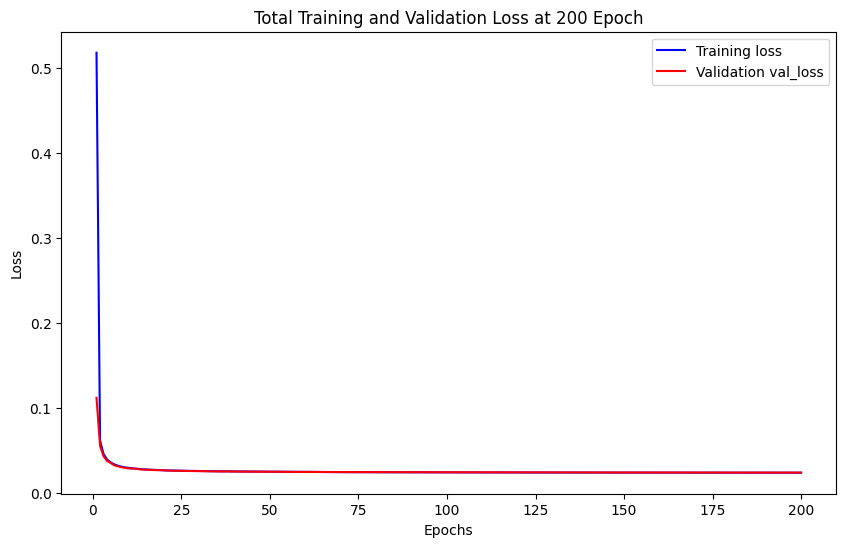

In [ ]:
plot_metric(history, 'loss', 'val_loss', 'Total Training and Validation Loss at 200 Epoch', 'Loss')


$\tau_1$, r'$\tau_2$', r'$A_1$', r'$A_2$'

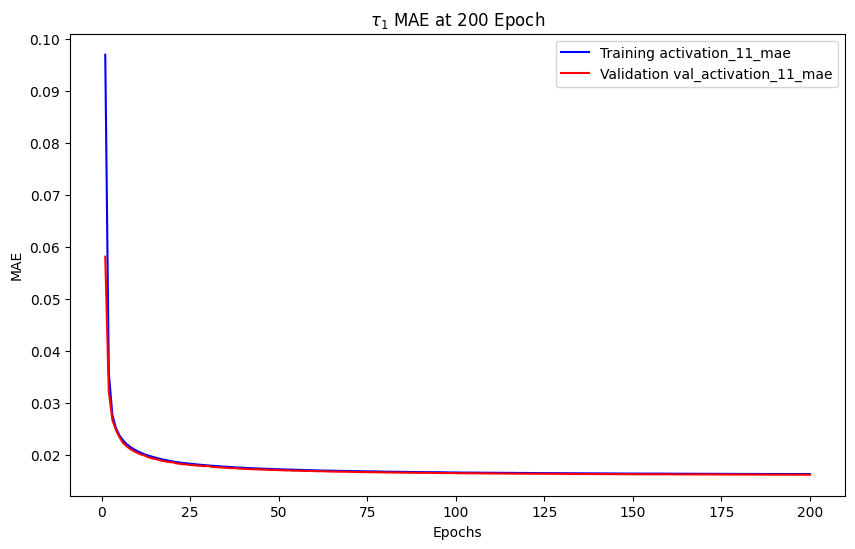

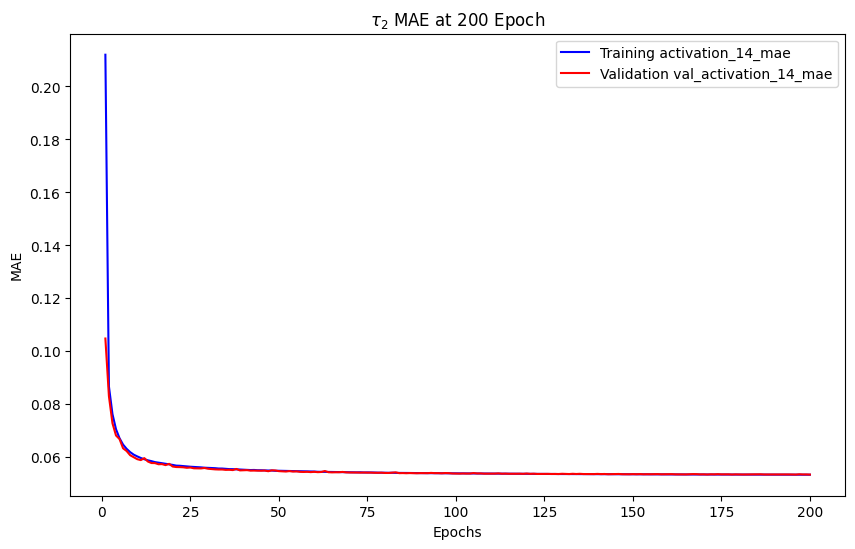

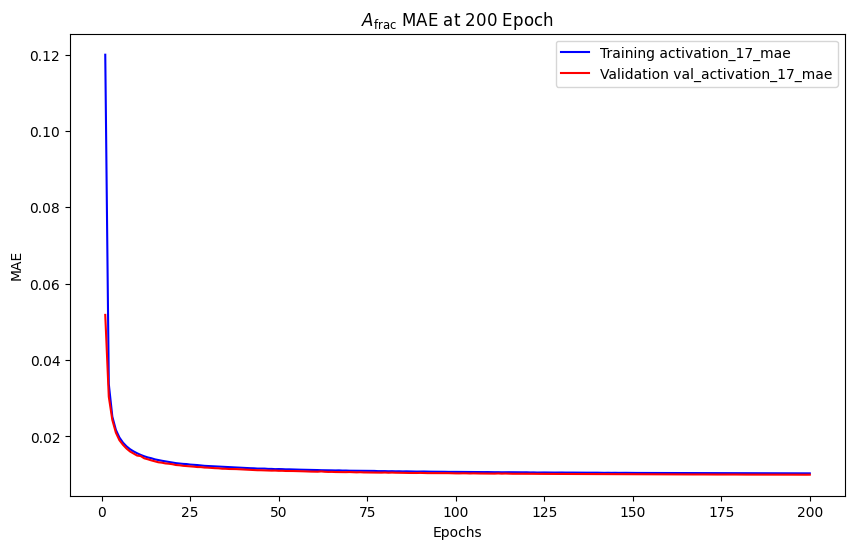

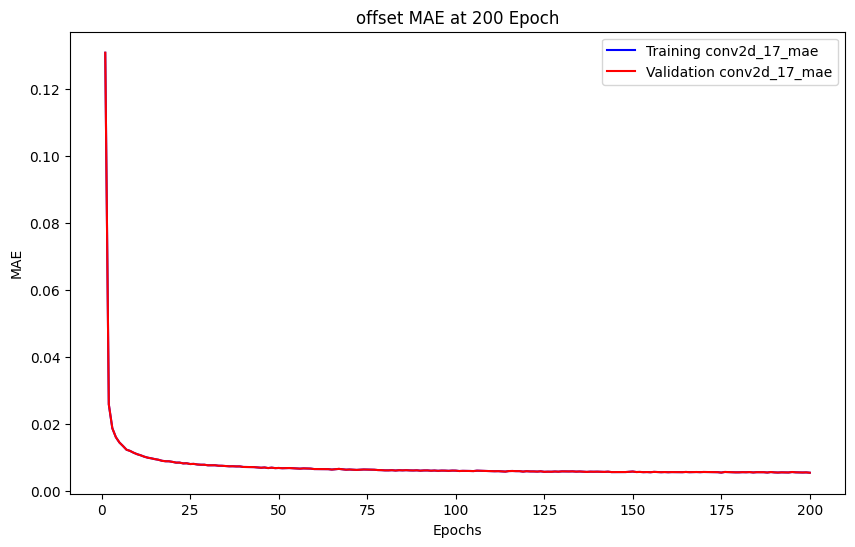

In [ ]:
plot_metric(history, 'activation_11_mae', 'val_activation_11_mae', r'$\tau_1$ MAE at 200 Epoch', 'MAE')
plot_metric(history, 'activation_14_mae', 'val_activation_14_mae', r'$\tau_2$ MAE at 200 Epoch', 'MAE')
plot_metric(history, 'activation_17_mae', 'val_activation_17_mae', r'$A_{\text{frac}}$ MAE at 200 Epoch', 'MAE')
#plot_metric(history, 'activation_20_mae', 'val_activation_20_mae', 'offset MAE at 100 Epoch', 'MAE')
plot_metric(history, 'conv2d_17_mae', 'conv2d_17_mae', 'offset MAE at 200 Epoch', 'MAE')
##plot_metric(history, 'activation_23_mae', 'val_activation_23_mae', 'offset MAE at 100 Epoch', 'MAE')

In [ ]:
fN = 'newest_model'

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Post-training: load "best" trained weights (obtained through patience - lowest value of loss)
# THIS CAN BE ANY WEIGHT FILE, AS LONG AS THE NETWORK ARCHITECTURE MATCHES THE ONE USED!
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

modelD.load_weights(fN+'.h5')

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model('/content/wawa_now_norm1.keras')

In [ ]:
model = load_model('/content/testName_50_300_250.h5')

In [ ]:
model = load_model('/content/testName_50_300_500.h5')

In [ ]:
# Upload test data and use 3D-CNN for inference

t_data = '/content/drive/MyDrive/abeg71'  # Directory with test data
stacks = os.listdir(t_data)
numS = len(stacks)

numS
nTG = 256  # Number of time-points
xX = 32
yY = 32

tpsfT = np.ndarray((numS, nTG, xX, yY, 1), dtype=np.float32)
t1T = np.ndarray((numS, xX, yY, 1), dtype=np.float32)
t2T = np.ndarray((numS, xX, yY, 1), dtype=np.float32)
a1T = np.ndarray((numS, xX, yY, 1), dtype=np.float32)
#a2T = np.ndarray((numS, xX, yY, 1), dtype=np.float32)
offsetT = np.ndarray((numS, xX, yY, 1), dtype=np.float32)

# Load data
i = 0

for d in stacks:
    # Load NPZ file
    data = np.load(os.path.join(t_data, d))

    # Transpose the data to match the expected shape and Save values to respective arrays
    tpsfT[i, :, :, :, 0] = np.transpose(data['sigD'], (2, 0, 1))
    t1T[i, :, :, 0] = data['t1']
    t2T[i, :, :, 0] = data['t2']
    a1T[i, :, :, 0] = data['a1']
    #a2T[i, :, :, 0] = data['a2']
    offsetT[i, :, :, 0] = data['offset']
    i += 1


# Adjust the axis if needed
tpsfT = np.moveaxis(tpsfT, 1, -2)

In [ ]:
numS

1

In [ ]:
tpsfT.shape

(1, 32, 32, 256, 1)

In [ ]:
# Perform inference on test data with trained model
testV = model.predict(tpsfT)
t1P = testV[0] # Predicted t1 values
t2P = testV[1] # Predicted t2 values
a1P = testV[2] # Predicted AR values
#a2P = testV[3] # Predicted AR values
offsetP = testV[3] # Predicted AR values

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
#testV

In [ ]:
n = 0

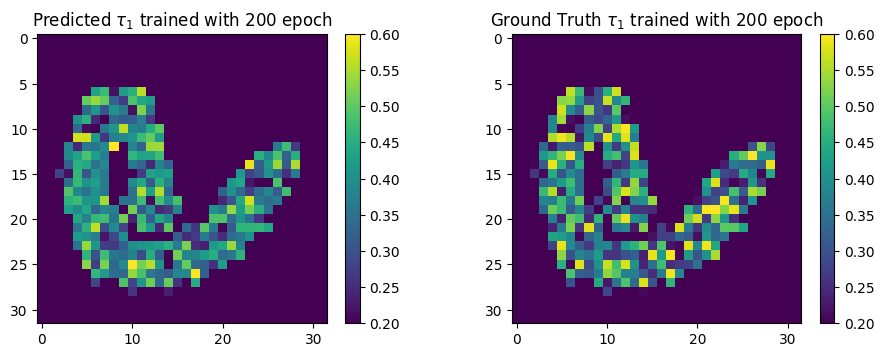

In [ ]:
# 100
n = 0
fig = plt.figure(figsize=(10,10))

# Predicted tau1
ax1 = fig.add_subplot(3,2,1)
im1 = ax1.imshow(t1P[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=.2, vmax=.6)
ax1.set_title(r'Predicted $\tau_1$ trained with 200 epoch')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# G.T. tau1
ax2 = fig.add_subplot(3,2,2)
im2 = ax2.imshow(t1T[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=.2, vmax=.6)
ax2.set_title(r'Ground Truth $\tau_1$ trained with 200 epoch')
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)



plt.tight_layout()
plt.show()


In [ ]:
plot_metric(history, 'activation_11_mae', 'val_activation_11_mae', r'$\tau_1$ MAE at 200 Epoch', 'MAE')
plot_metric(history, 'activation_14_mae', 'val_activation_14_mae', r'$\tau_2$ MAE at 200 Epoch', 'MAE')
plot_metric(history, 'activation_17_mae', 'val_activation_17_mae', r'$A_{\text{frac}}$ MAE at 200 Epoch', 'MAE')

In [ ]:
# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(t1P[n, :, :, 0], t1T[n, :, :, 0], data_range=t1P[n, :, :, 0].max() - t1P[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")



SSIM for the image at index 0: 0.9595036899020686


Tau2

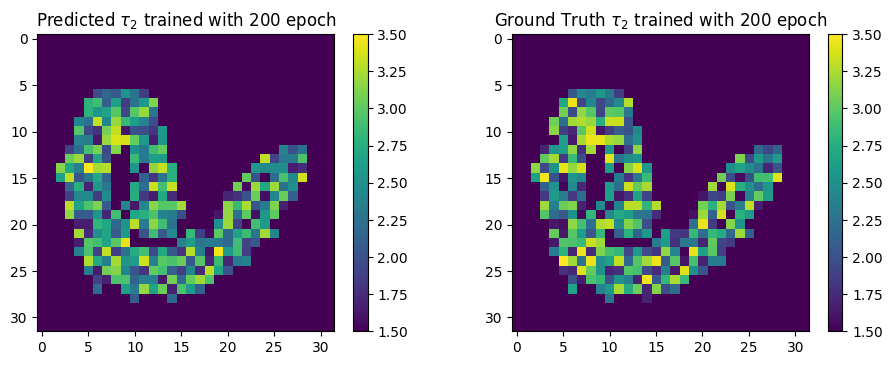

In [ ]:

fig = plt.figure(figsize=(10,10))
# Predicted tau2
ax3 = fig.add_subplot(3,2,3)
im3 = ax3.imshow(t2P[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=1.5, vmax=3.5)
ax3.set_title(r'Predicted $\tau_2$ trained with 200 epoch')
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)


# G.T. tau2
ax4 = fig.add_subplot(3,2,4)
im4 = ax4.imshow(t2T[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=1.5, vmax=3.5)
ax4.set_title(r'Ground Truth $\tau_2$ trained with 200 epoch')
fig.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)


plt.tight_layout()
plt.show()





In [ ]:
# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(t2P[n, :, :, 0], t2T[n, :, :, 0], data_range=t2P[n, :, :, 0].max() - t2P[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")


SSIM for the image at index 0: 0.9901141352378405


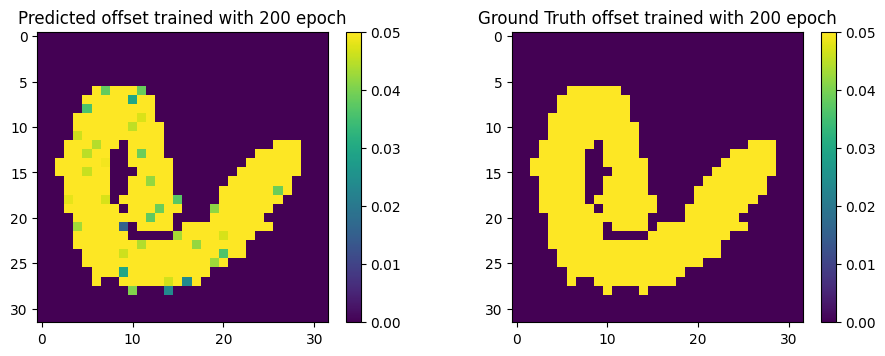

In [ ]:
n=0
fig = plt.figure(figsize=(10,10))

# Predicted AR
ax5 = fig.add_subplot(3,2,5)
im5 = ax5.imshow(offsetP[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=0.05)
ax5.set_title('Predicted offset trained with 200 epoch')
fig.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)
# G.T. tau1
ax6 = fig.add_subplot(3,2,6)
im6 = ax6.imshow(offsetT[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=0.05)
ax6.set_title('Ground Truth offset trained with 200 epoch')
fig.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)



plt.tight_layout()
plt.show()

In [ ]:

# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(offsetP[n, :, :, 0], offsetT[n, :, :, 0], data_range=offsetP[n, :, :, 0].max() - offsetP[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")

SSIM for the image at index 0: 0.9227438373325845


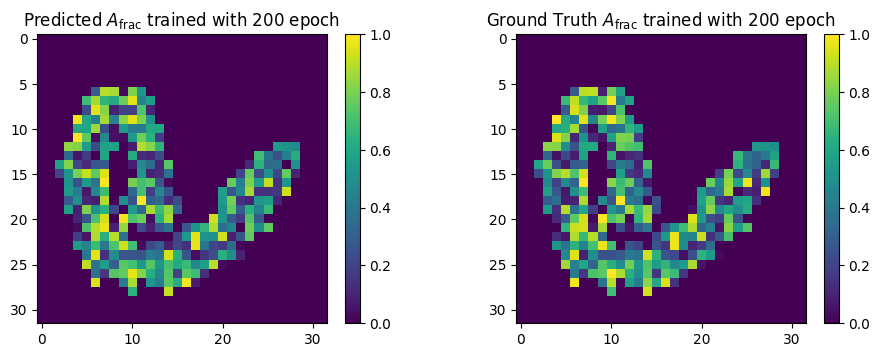

In [ ]:
n =0
fig = plt.figure(figsize=(10,10))

# Predicted AR
ax5 = fig.add_subplot(3,2,5)
im5 = ax5.imshow(a1P[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
ax5.set_title(r'Predicted $A_{\text{frac}}$ trained with 200 epoch')
fig.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)
# G.T. tau1
ax6 = fig.add_subplot(3,2,6)
im6 = ax6.imshow(a1T[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
ax6.set_title(r'Ground Truth $A_{\text{frac}}$ trained with 200 epoch')
fig.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)



plt.tight_layout()
plt.show()

In [ ]:

# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(a1P[n, :, :, 0], a1T[n, :, :, 0], data_range=a1T[n, :, :, 0].max() - a1T[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")

SSIM for the image at index 0: 0.9933317606089384


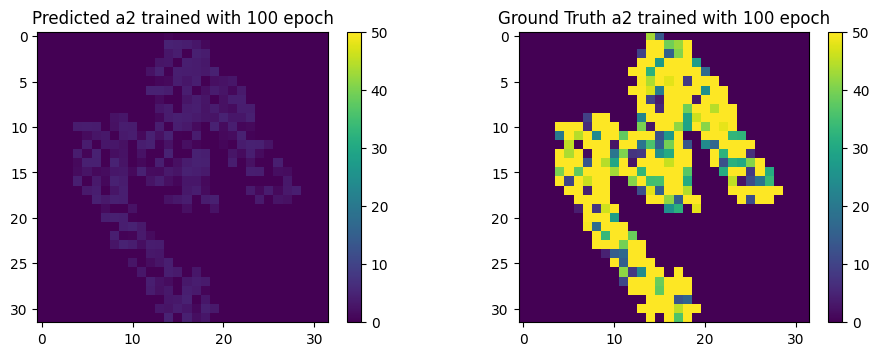

In [ ]:

fig = plt.figure(figsize=(10,10))

# Predicted AR
ax5 = fig.add_subplot(3,2,5)
im5 = ax5.imshow(a2P[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=50)
ax5.set_title('Predicted a2 trained with 100 epoch')
fig.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)
# G.T. tau1
ax6 = fig.add_subplot(3,2,6)
im6 = ax6.imshow(a2T[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=50)
ax6.set_title('Ground Truth a2 trained with 100 epoch')
fig.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)



plt.tight_layout()
plt.show()

In [ ]:

# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(a2P[n, :, :, 0], a2T[n, :, :, 0], data_range=a2T[n, :, :, 0].max() - a2T[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")

SSIM for the image at index 0: 0.14929219311001274


In [ ]:
offsetT[n, :, :, 0].max()

0.04999671

In [ ]:
t1 = t1P[n,:,:,0]
t2 = t2P[n,:,:,0]
# Dividing by 100 to convert percentage for a1
a1 = tRP[n,:,:,0]

# Calculate tM based on the formula provided
tM_model = a1 * t1 + (1 - a1) * t2

t1 = t1T[n,:,:,0]
t2 = t2T[n,:,:,0]
# Dividing by 100 to convert percentage for a1
a1 = tRT[n,:,:,0]

# Calculate tM based on the formula provided
tM_GT = a1 * t1 + (1 - a1) * t2